# <a id='env'>1. Setting up the Environment</a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [6]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 93% 14.0M/15.1M [00:00<00:00, 141MB/s]
100% 15.1M/15.1M [00:00<00:00, 139MB/s]


In [7]:
!ls

brain-mri-images-for-brain-tumor-detection.zip	kereas_pretrained_model
kaggle.json


In [8]:
!unzip \*.zip  && rm *.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

In [9]:
!pip install imutils

In [10]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    
import time

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [11]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

# <a id='import'>2. Data Import and Preprocessing</a>

In [12]:
image_dir="../Kaggle/brain_tumor_dataset/"

In [13]:
os.makedirs('../output/kaggle/working/augmented-images', exist_ok = True)
os.makedirs('../output/kaggle/working/augmented-images/yes', exist_ok = True)
os.makedirs('../output/kaggle/working/augmented-images/no', exist_ok = True)

augmented_data_path ='../output/kaggle/working/augmented-images/'

augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_SIZE = (224,224)

In [14]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [15]:
dir = os.listdir('../output/kaggle/working/augmented-images/yes') 
start_time = time.time()

if len(dir) == 0: 
    augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
    augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')
else:
    print(len(dir))
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:1:46.0


In [16]:
def data_summary():    
    m_pos = len(listdir(augmented_yes))
    m_neg = len(listdir(augmented_no))
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 

In [17]:
data_summary()

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [18]:
def load_data(dir_list):
    X = []
    y = []
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            X.append(image)

            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [19]:
def plot_samples(X, y, labels_dict, n=50):
    flag=0
    for index in range(0,len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
      
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        if flag==0:
          plt.suptitle('Tumor :No')
        else:
           plt.suptitle('Tumor :Yes')
        flag+=1
        plt.show()

In [20]:

X_train, y_train = load_data([augmented_yes, augmented_no])

Number of examples is: 2065
X shape is: (2065,)
y shape is: (2065, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


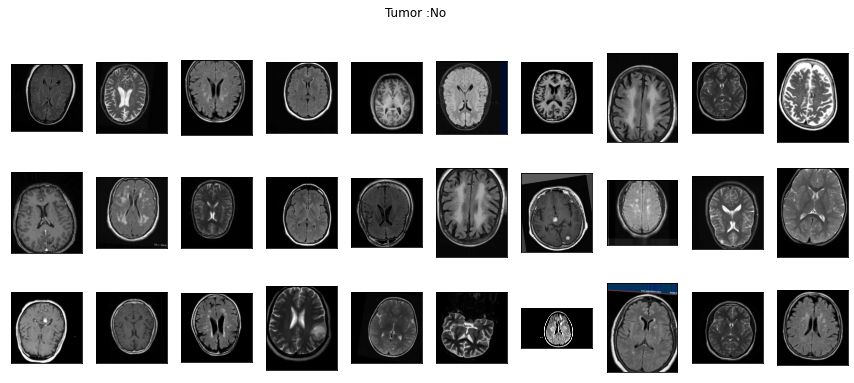

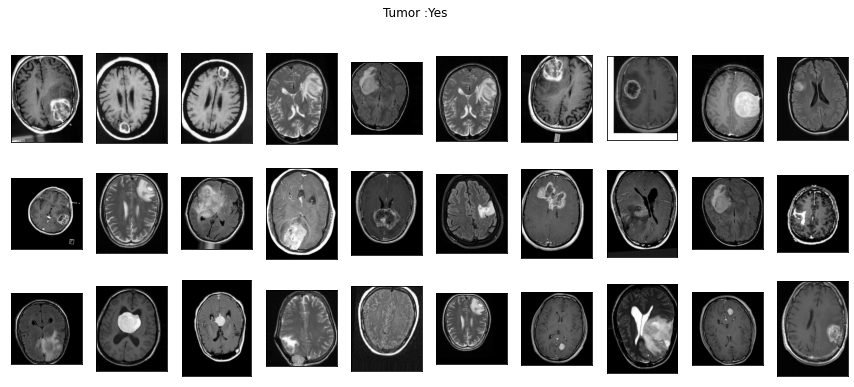

In [21]:
plot_samples(X_train, y_train, ['yes','no'], 30)

In [23]:
def crop_brain_contour(image, plot=False):
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

   
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [24]:
img = cv2.imread('../Kaggle/brain_tumor_dataset/yes/Y9.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)


thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)


cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)


extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])


img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)


img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)


ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

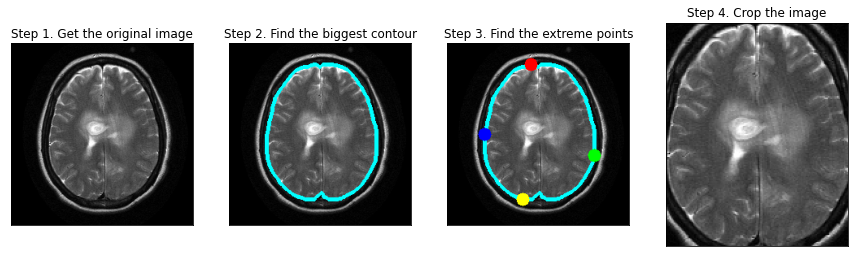

In [25]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [26]:
def Croping_Data(train):

    X = []
    y = []
    
    for img in train:
        image = crop_brain_contour(img, plot=False)
        X.append(image)
                
    X = np.array(X)
    
    return X

In [27]:
X = Croping_Data(X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


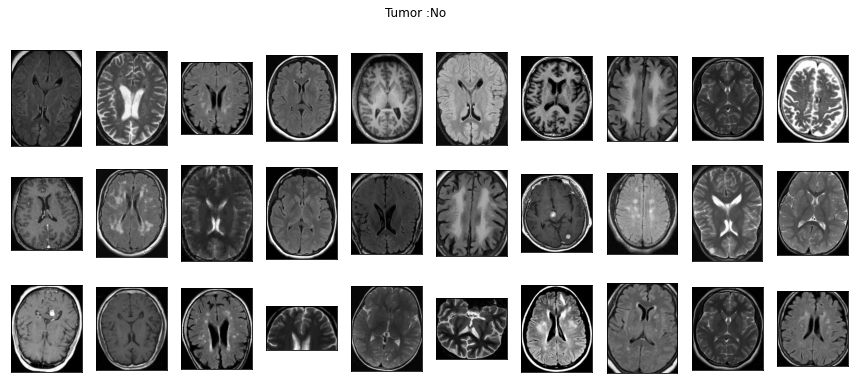

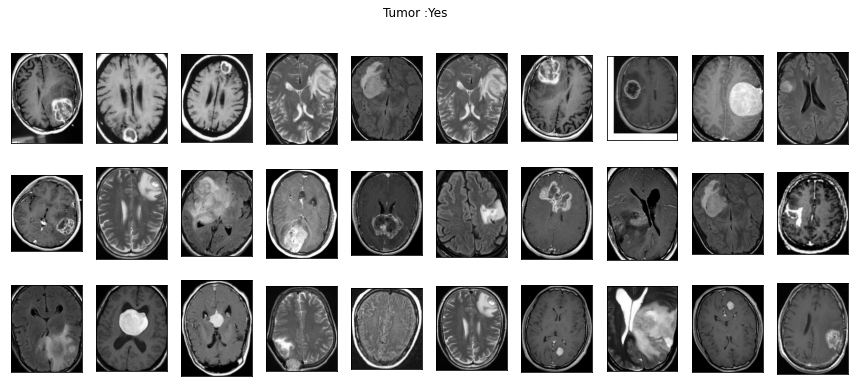

In [28]:
plot_samples(X, y_train, ['yes','no'], 30)

In [29]:
def Resize_Data(train):

    X = []
    y = []
    
    IMG_WIDTH, IMG_HEIGHT = (240, 240)
    
    for img in train:
        image = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
        
        image = image / 255.
    
        X.append(image)
                
    X = np.array(X)
    
    return X

In [30]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X = Resize_Data(X)
y = y_train



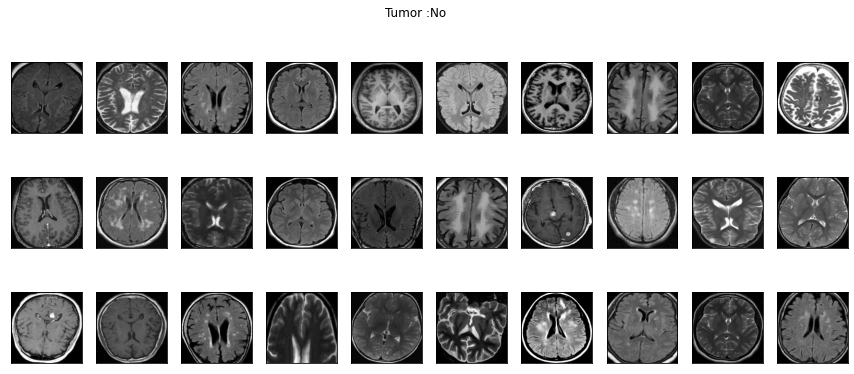

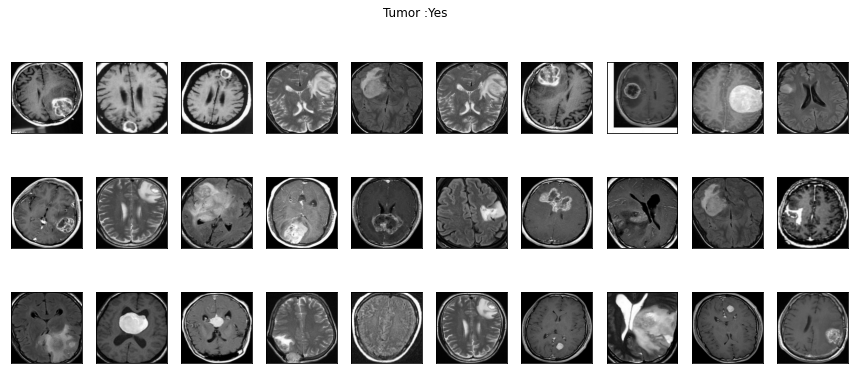

In [31]:
plot_samples(X, y_train, ['yes','no'],30)

## Visualization of data

In [32]:
def split_data(X, y, test_size=0.3):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [33]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [34]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1445
number of validation examples = 310
number of test examples = 310


In [35]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

## <a id='build'>4. MODEL BUILDING</a>

## 4.1. MODEL WITHOUT VGG-16 (MODEL FROM BASE)

In [36]:
def build_model(input_shape):
  
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    
    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    print(model)
    
    return model

In [37]:
IMG_SHAPE=(240,240,3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0     

In [38]:
from sklearn.metrics import f1_score
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [39]:

labels = ['yes','no']

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [42]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val), callbacks=[tensorboard])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/25
46/46 [==============================] - 36s 110ms/step - loss: 0.6749 - accuracy: 0.6740 - val_loss: 0.6421 - val_accuracy: 0.6516
Epoch 2/25
46/46 [==============================] - 3s 63ms/step - loss: 0.4604 - accuracy: 0.7896 - val_loss: 0.6667 - val_accuracy: 0.5484
Epoch 3/25
46/46 [==============================] - 3s 62ms/step - loss: 0.4097 - accuracy: 0.8201 - val_loss: 0.7767 - val_accuracy: 0.5032
Epoch 4/25
46/46 [==============================] - 3s 62ms/step - loss: 0.5619 - accuracy: 0.7419 - val_loss: 0.5314 - val_accuracy: 0.7290
Epoch 5/25
46/46 [==============================] - 3s 62ms/step - loss: 0.3291 - accuracy: 0.8657 - val_loss: 0.7301 - val_accuracy: 0.5871
Epoch 6/25
46/46 [==============================] - 3s 62ms/step - loss: 0.2712 - accuracy: 0.8969 - val_loss: 0.6182 - val_accuracy: 0.6645
Epoch 7/25
46/46 [==============================] - 3s 61ms/step - loss: 0.2733 - accuracy: 0.8983 - val_loss: 0.5821 - val_accuracy: 0.7194
Epoch 8/25


In [43]:
history = model.history.history

In [44]:
model.metrics_names

['loss', 'accuracy']

In [45]:
loss, acc = model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 0s 30ms/step - loss: 0.3581 - accuracy: 0.8935


In [46]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.3581485450267792
Test Accuracy = 0.8935483694076538


In [47]:
y_val_prob = model.predict(X_val)

In [48]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8656716417910448


In [49]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 


In [50]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.8719723183391%, number of pos examples: 764
Percentage of negative examples: 47.1280276816609%, number of neg examples: 681
Validation Data:
Number of examples: 310
Percentage of positive examples: 53.54838709677419%, number of pos examples: 166
Percentage of negative examples: 46.45161290322581%, number of neg examples: 144
Testing Data:
Number of examples: 310
Percentage of positive examples: 50.0%, number of pos examples: 155
Percentage of negative examples: 50.0%, number of neg examples: 155


### 4.2 MODEL WITH VGG-16

In [51]:

from sklearn.model_selection import KFold
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

vgg16_weight_path = '../Kaggle/kereas_pretrained_model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_model = VGG16(weights=vgg16_weight_path,include_top=False, input_shape=IMG_SHAPE)


In [52]:
NUM_CLASSES = 1

model1= Sequential()
model1.add(vgg16_model)
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model1.layers[0].trainable = False

model1.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model1.summary()


model1.layers[0].trainable = False


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [53]:
start_time = time.time()

model1.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[tensorboard])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/30
46/46 [==============================] - 42s 475ms/step - loss: 0.7295 - accuracy: 0.5588 - val_loss: 0.5685 - val_accuracy: 0.7548
Epoch 2/30
46/46 [==============================] - 9s 201ms/step - loss: 0.6085 - accuracy: 0.6608 - val_loss: 0.5186 - val_accuracy: 0.7516
Epoch 3/30
46/46 [==============================] - 10s 219ms/step - loss: 0.5198 - accuracy: 0.7425 - val_loss: 0.4665 - val_accuracy: 0.8323
Epoch 4/30
46/46 [==============================] - 9s 196ms/step - loss: 0.4493 - accuracy: 0.7868 - val_loss: 0.4468 - val_accuracy: 0.8097
Epoch 5/30
46/46 [==============================] - 9s 195ms/step - loss: 0.4128 - accuracy: 0.8220 - val_loss: 0.3955 - val_accuracy: 0.8710
Epoch 6/30
46/46 [==============================] - 10s 216ms/step - loss: 0.3794 - accuracy: 0.8380 - val_loss: 0.3791 - val_accuracy: 0.8419
Epoch 7/30
46/46 [==============================] - 10s 217ms/step - loss: 0.3375 - accuracy: 0.8624 - val_loss: 0.3502 - val_accuracy: 0.8903
Ep

In [54]:
history = model1.history.history

In [55]:
model1.metrics_names

['loss', 'accuracy']

In [56]:
loss, acc = model1.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 2s 160ms/step - loss: 0.1694 - accuracy: 0.9516


In [57]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")


Test Loss = 0.16935327649116516
Test Accuracy = 0.9516128897666931


In [58]:
y_val_prob = model1.predict(X_val)

In [59]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.959752321981424


In [60]:
os.makedirs('../output/Model', exist_ok = True)

In [61]:
%cd /content/gdrive/My Drive/output/Model

/content/gdrive/My Drive/output/Model


In [62]:
!model1.save('Final_VGG_model.h5')

/bin/bash: -c: line 0: syntax error near unexpected token `'Final_VGG_model.h5''
/bin/bash: -c: line 0: `model1.save('Final_VGG_model.h5')'


## THE END...